Import Libraries 

In [1]:
# Utilities
import numpy as np
import pandas as pd

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Deep Learning
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, History
from keras.initializers import Initializer
import tensorflow.keras.backend as K

# Visualization
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe_connected'# static plotly
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
df = pd.read_excel('./emazzy.xlsx')

In [3]:
df.head()

,Period,Gold Price
0,1,1223.8
1,2,1237.5
2,3,1243.8
3,4,1258.0
4,5,1260.9


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1566 entries, 0 to 1565
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Period      1566 non-null   int64  
 1   Gold Price  1566 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 24.6 KB


Custom RBF Layer

In [5]:
# Define RBFLayer class
class RBFLayer(Dense):
    def __init__(self, units, initializer=None, betas=1.0, **kwargs):
        super(RBFLayer, self).__init__(units, **kwargs)
        self.betas = betas
        self.initializer = initializer

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        if self.initializer is not None:
            self.centers = self.add_weight(name='centers',
                                           shape=(self.units, input_dim),
                                           initializer=self.initializer,
                                           trainable=True)
        else:
            self.centers = self.add_weight(name='centers',
                                           shape=(self.units, input_dim),
                                           initializer='uniform',
                                           trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        c = self.centers
        x = inputs[:, None]
        distances = K.sum(K.square(x - c), axis=-1)
        output = K.exp(-self.betas * distances)
        return output

In [6]:
# Custom initializer for initializing centers randomly
class InitCentersRandom(Initializer):
    def __init__(self, X):
        self.X = X

    def __call__(self, shape, dtype=None):
        assert shape[1:] == self.X.shape[1:]
        idx = np.random.choice(self.X.shape[0], shape[0], replace=False)
        return self.X[idx, :]

Preparing for training 

In [7]:
X = df[['Period']].values
y = df['Gold Price'].values
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

Build Neural Network Model



In [9]:
# Build RBF neural network model
model = Sequential([
    RBFLayer(1, initializer=InitCentersRandom(X_train), betas=2.0, input_shape=(1,)),
    Dense(100, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

In [10]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [12]:
history = model.fit(X_train, y_train, batch_size=16, epochs=500, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1017 - val_loss: 0.0453
Epoch 2/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0500 - val_loss: 0.0331
Epoch 3/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0315 - val_loss: 0.0245
Epoch 4/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0246 - val_loss: 0.0185
Epoch 5/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0227 - val_loss: 0.0161
Epoch 6/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0188 - val_loss: 0.0143
Epoch 7/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0182 - val_loss: 0.0131
Epoch 8/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0150 - val_loss: 0.0117
Epoch 9/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0143 - val_loss: 0.0108
Epoch 10/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0136 - val_loss: 0.0104
Epoch 11/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0122 - val_loss: 0.0103
Epoch 12/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0

Plot

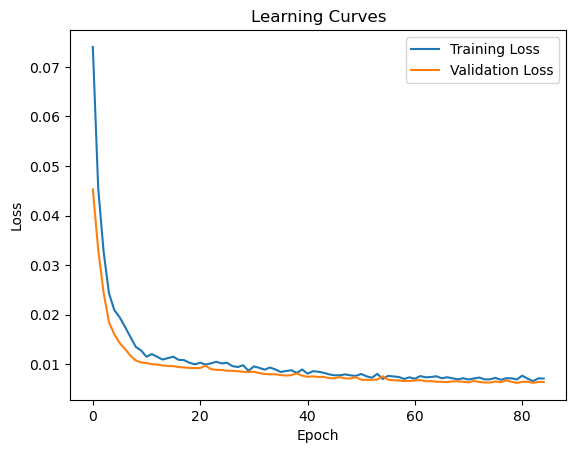

In [13]:
# Plot learning curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Evaluation

In [14]:
# Evaluate the model
mse = model.evaluate(X_test, y_test)

# Make predictions
predictions = model.predict(X_test)
predictions = scaler_y.inverse_transform(predictions)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0054 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [15]:
# Invert the scaled y_test values back to original scale using scaler_y
y_test_original = scaler_y.inverse_transform(y_test)

# Convert predictions and actual values to DataFrame for easier manipulation
results_df = pd.DataFrame({'Actual': y_test_original.flatten(), 'Predicted': predictions.flatten()})

# Create a scatter plot
fig = go.Figure()

fig.add_trace(go.Scatter(x=results_df.index, y=results_df['Actual'], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=results_df.index, y=results_df['Predicted'], mode='lines', name='Predicted'))

fig.update_layout(title='Actual vs Predicted Gold Price',
                  xaxis_title='Period',
                  yaxis_title='Gold Price (Original Scale)',
                  legend=dict(x=0, y=1, traceorder='normal'))

fig.update_layout(height=300, width=1300, showlegend=False)

fig.show()

In [16]:
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.006052051670849323
